In [1]:
import pickle

import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

from shapely.geometry import MultiPoint

In [2]:
from pylab import rcParams
rcParams['figure.figsize'] = 20, 8

In [3]:
INPUT_FOLDER = "../input"
DATA = f"{INPUT_FOLDER}/accidents.csv"

In [4]:
def read_pickle(fname):
    with open(f"{INPUT_FOLDER}/{fname}.pickle", "rb") as f:
        return pickle.load(f)


In [5]:
accidents_only_roads_gdf = read_pickle("accidents_enriched_gdf")
pois_gdf = read_pickle("pois_gdf")
places_gdf = read_pickle("places_gdf")
ways_gdf = read_pickle("ways_gdf")
shape_gdf = read_pickle("shape_gdf")

In [6]:
one_meter = 0.00001

In [7]:
pois_gdf["geometry_circle=25m"] = pois_gdf["geometry"].buffer(one_meter * 25)
pois_gdf["geometry_circle=10m"] = pois_gdf["geometry"].buffer(one_meter * 10)

In [8]:
if "index_right" in pois_gdf.columns: del pois_gdf["index_right"]
if "index_right" in accidents_only_roads_gdf.columns: del accidents_only_roads_gdf["index_right"]

In [9]:
def pois_intersection_plot(title, gdf, accidents):
    fig, axes = plt.subplots(nrows=1, ncols=2)
    fig.suptitle(title)
    (
        gpd.sjoin(
            accidents,
            gdf.set_geometry("geometry_circle=10m"),
            op="within"
        ).reset_index()
        .groupby("index")["index"].count()
    ).value_counts().plot(
        kind="bar", 
        title="10m",
        ax=axes[0]
    )
    (
        gpd.sjoin(
            accidents,
            gdf.set_geometry("geometry_circle=25m"),
            op="within"
        ).reset_index()
        .groupby("index")["index"].count()
    ).value_counts().plot(
        kind="bar", 
        title="25m",
        ax=axes[1]
    )
    
    return fig.show()


####  Wypadki, a przejścia dla pieszych.

Część przejść dla pieszych oznaczona jest jako **Node** w Open Street Map, jeszcze inna jako **Way**. W naszym przypadku sprowadza się to do zaglądnięcia do różnych geodata frameów. Dorzućmy do POI przejścia dla pieszych z geo data framu zawierającego odcinki dróg.

\[1\] https://wiki.openstreetmap.org/wiki/Key:crossing


In [10]:
crosswalks = ~ways_gdf["tags"].apply(lambda x: x.get("crossing", np.nan) or x.get("footway", np.nan)).isna()
crosswalks_gdf = ways_gdf[crosswalks].copy().set_geometry("geometry")
crosswalks_gdf["geometry"] = crosswalks_gdf.centroid
crosswalks_gdf["geometry_circle=25m"] = crosswalks_gdf["geometry"].buffer(one_meter * 25)
crosswalks_gdf["geometry_circle=10m"] = crosswalks_gdf["geometry"].buffer(one_meter * 10)
crosswalks_gdf.shape

(4316, 5)

<ipython-input-9-94674a153199>:29: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  return fig.show()


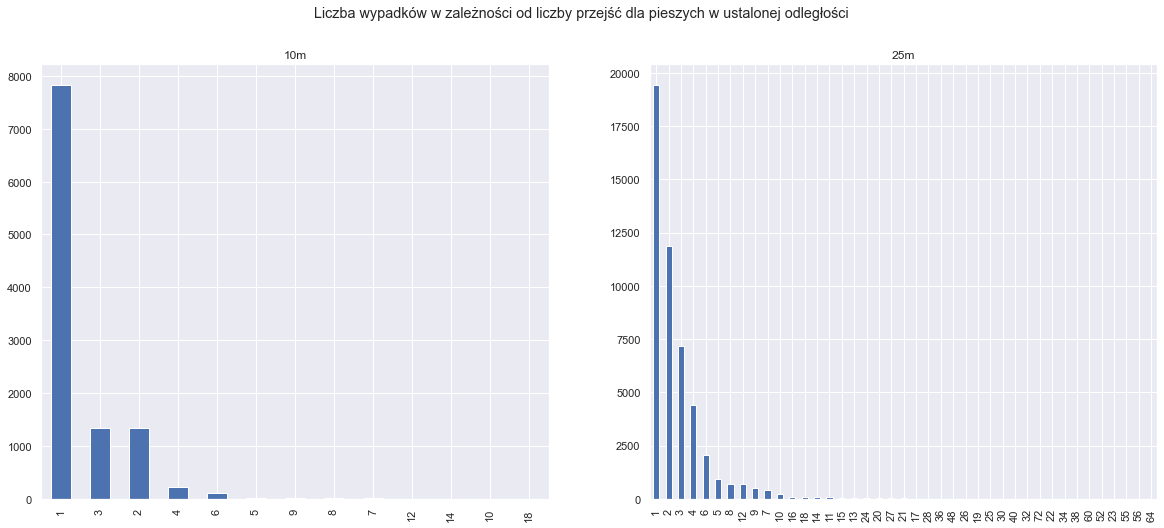

In [12]:
pois_gdf = pd.concat([pois_gdf, crosswalks_gdf])

pois_gdf["footway"] = pois_gdf["tags"].apply(lambda x: x.get("footway", np.nan))
pois_gdf["crossing"] = pois_gdf["tags"].apply(lambda x: x.get("crossing", np.nan))
pois_gdf["highway"] = pois_gdf["tags"].apply(lambda x: x.get("highway", np.nan))

pois_intersection_plot(
    "Liczba wypadków w zależności od liczby przejść dla pieszych w ustalonej odległości", 
    pois_gdf[ 
        (pois_gdf["footway"] == "crossing") | 
        (~pois_gdf["crossing"].isna()) | 
        (pois_gdf["highway"] == "crossing")
    ],
    accidents_only_roads_gdf
)

####  Wypadki, a skrzyżowania.

Nie ma skrzyżowań bezpośrednio podanych w OSM, trzeba to policzyć. Ale istnieje łatwy sposób na policzenie tego bez spatial joina.

https://help.openstreetmap.org/questions/15442/detection-of-intersections-in-the-maps

#### Wypadki, a rondo.

W naszych POI tych rond nie ma za wiele. 

Krótka zabawa z OverpassAPI pokazuje, że ronda są częściej oznaczone przy użyciu obiektów typu **Way**, a nie **Node**([2]). Dodatkowo, widać, że jedno rondo składa się z kilku odcinków drogi, więc szukając czy w pobliżu wypadku jest jakieś rondo, znaleźlibyśmy kilka - trzeba to naprawić.

Naprawa wygląda mniej więcej tak:
    
1. Wyznacz środek każdego odcinka drogi reprezentujący rondo
2. Zamień punkt w okrąg o ustalonym promieniu
3. Zrób spatial joina szukając przecięć okręgów (dzięki temu, wiemy które punkty są blisko siebie i prawdopodobnie reprezentują jedno rondo
4. Zdeduplikuj dane: 

    - pozostaw tagi dowolonego elementu
    - policz ile odcinków składało się na to jedno rondo
    - wyznacz otoczkę wypukłą (minimalny taki wielokąt, że każdy punkt zawiera się w tym okręgu)
    - wyznacz środek otoczki wypukłej - to będzie środek naszego ronda


[1] https://wiki.openstreetmap.org/wiki/Tag:junction%3Droundabout

[2] https://overpass-turbo.eu/s/V3h

In [13]:
roundabouts = ~ways_gdf["tags"].apply(lambda x: x.get("junction", np.nan)).isna()
roundabouts_gdf = ways_gdf[roundabouts].copy()

roundabouts_gdf["representative_point"] = (
    roundabouts_gdf["geometry"].centroid
)
roundabouts_gdf["buffer"] = (
    roundabouts_gdf.set_geometry("representative_point")["representative_point"].buffer(one_meter * 10)
)

roundabouts_gdf = gpd.sjoin(
    roundabouts_gdf.set_geometry("buffer"), 
    roundabouts_gdf.set_geometry("buffer"), 
    op="intersects"
).drop_duplicates("id_left").groupby("index_right").agg(
    id=("id_left", "first"),
    tags=("tags_left", "first"),
    geometry=("representative_point_left", list),
    count=("representative_point_left", "count"),
)
roundabouts_gdf["geometry"] = roundabouts_gdf["geometry"].apply(lambda x: MultiPoint(x))
roundabouts_gdf["geometry"] = roundabouts_gdf.set_geometry("geometry").convex_hull.centroid
roundabouts_gdf = roundabouts_gdf.set_geometry("geometry")
roundabouts_gdf["geometry_circle=25m"] = roundabouts_gdf["geometry"].buffer(one_meter * 25)
roundabouts_gdf["geometry_circle=10m"] = roundabouts_gdf["geometry"].buffer(one_meter * 10)
roundabouts_gdf.index = roundabouts_gdf.index.rename("index")
roundabouts_gdf.shape

(1452, 6)

<ipython-input-9-94674a153199>:29: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  return fig.show()


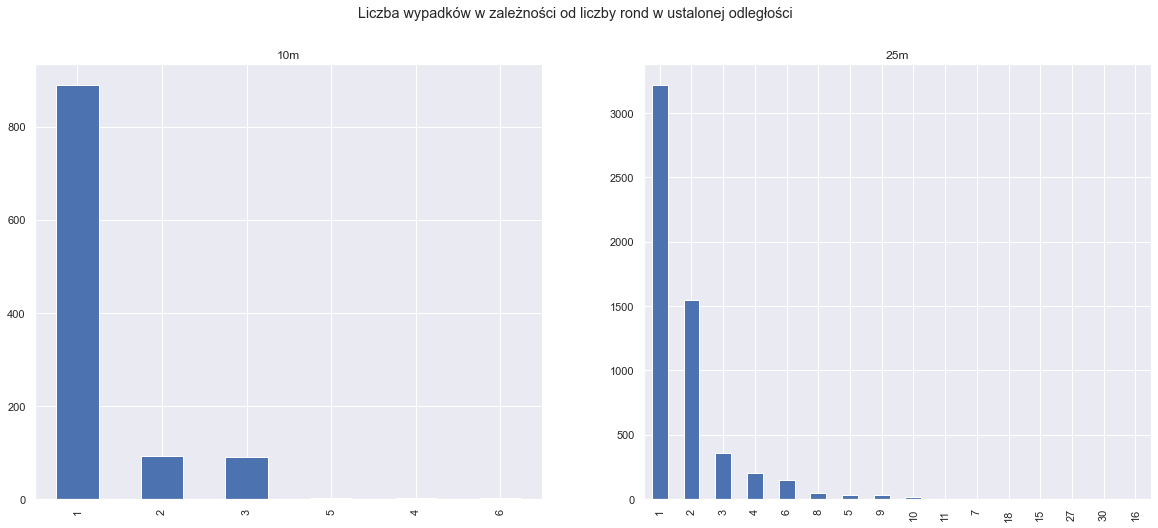

In [14]:
pois_gdf = pd.concat([pois_gdf, roundabouts_gdf])
pois_gdf["junction"] = pois_gdf["tags"].apply(lambda x: x.get("junction", np.nan))

pois_intersection_plot(
    "Liczba wypadków w zależności od liczby rond w ustalonej odległości", 
    pois_gdf[(pois_gdf["junction"] == "yes") | (pois_gdf["junction"] == "roundabout")],
    accidents_only_roads_gdf
)

#### Wypadki, a światła.

[1] https://wiki.openstreetmap.org/wiki/Tag:highway%3Dtraffic_signals

In [15]:
traffic_signals_gdf = ways_gdf[
    (ways_gdf["tags"].apply(lambda x: x.get("crossing", np.nan)) == "traffic_signals")
]

<ipython-input-9-94674a153199>:29: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  return fig.show()


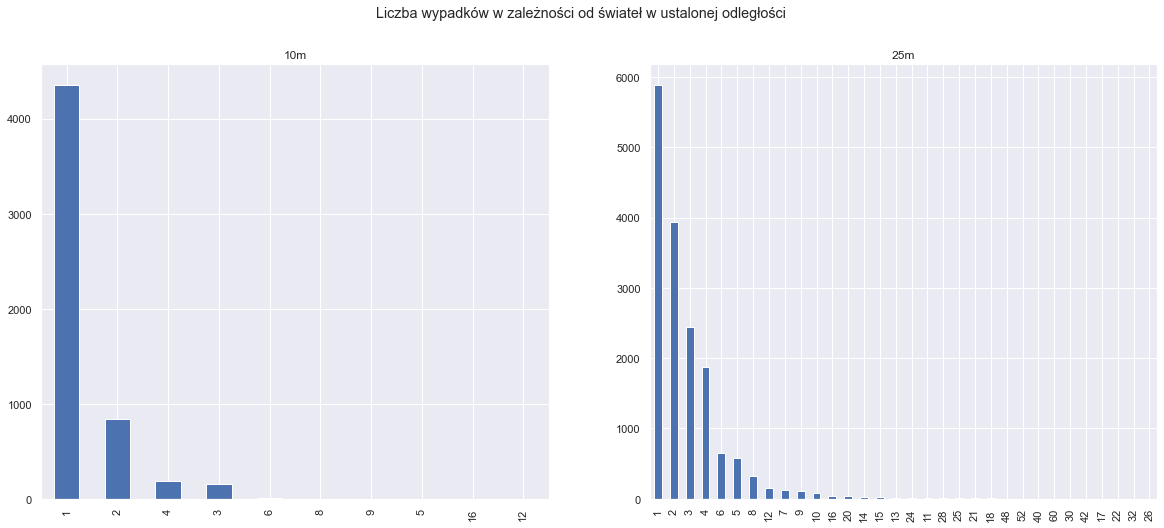

In [16]:
pois_gdf = pd.concat([pois_gdf, traffic_signals_gdf])
pois_intersection_plot(
    "Liczba wypadków w zależności od świateł w ustalonej odległości", 
    pois_gdf[(pois_gdf["highway"] == "traffic_signals") | (pois_gdf["crossing"] == "traffic_signals")],
    accidents_only_roads_gdf
)

#### Wypadek, a dozwolona prędkość.

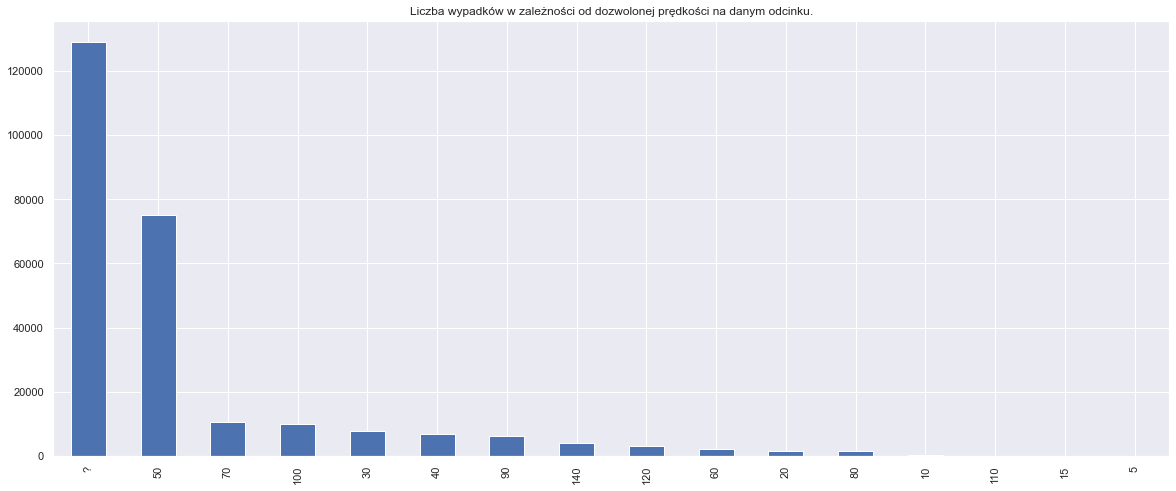

In [17]:
accidents_only_roads_gdf["max_speed"] = accidents_only_roads_gdf["tags"].apply(
    lambda x: x.get("maxspeed", "?")
)
(
    accidents_only_roads_gdf["max_speed"].value_counts()
        .plot(kind="bar", title="Liczba wypadków w zależności od dozwolonej prędkości na danym odcinku.")
)

#### Wypadek, a dozwolona prędkość w okolicy przejścia dla pieszych.

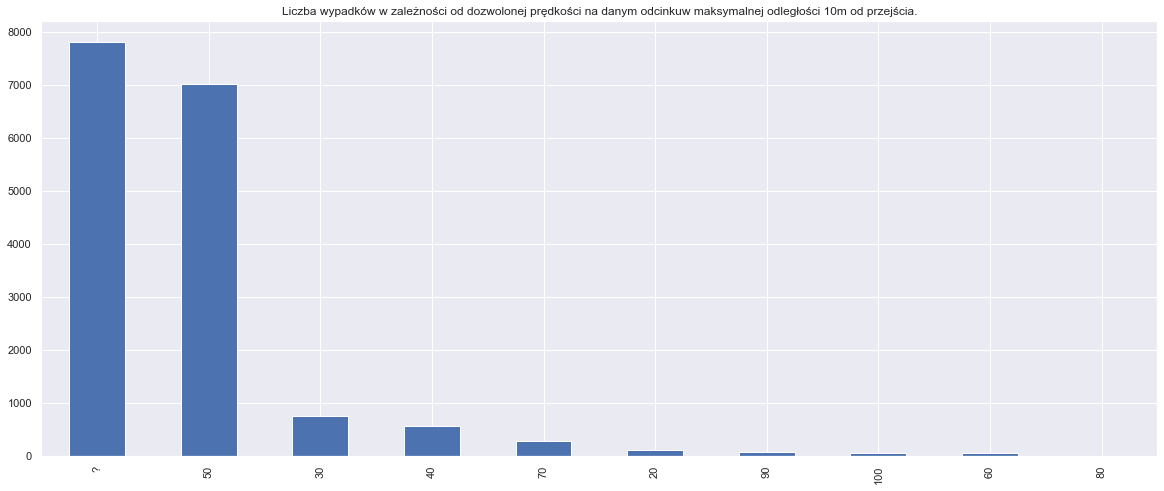

In [21]:
(
    gpd.sjoin(
    accidents_only_roads_gdf,
        pois_gdf[ 
            (pois_gdf["footway"] == "crossing") | 
            (~pois_gdf["crossing"].isna()) | 
            (pois_gdf["highway"] == "crossing")
        ].set_geometry("geometry_circle=10m"),
        op="within"
    )["max_speed"].value_counts()
        .plot(
            kind="bar", title=(
                "Liczba wypadków w zależności od dozwolonej prędkości na danym odcinku " 
                "w maksymalnej odległości 10m od przejścia."
            )
        )
)

#### Wypadek, a typ drogi.

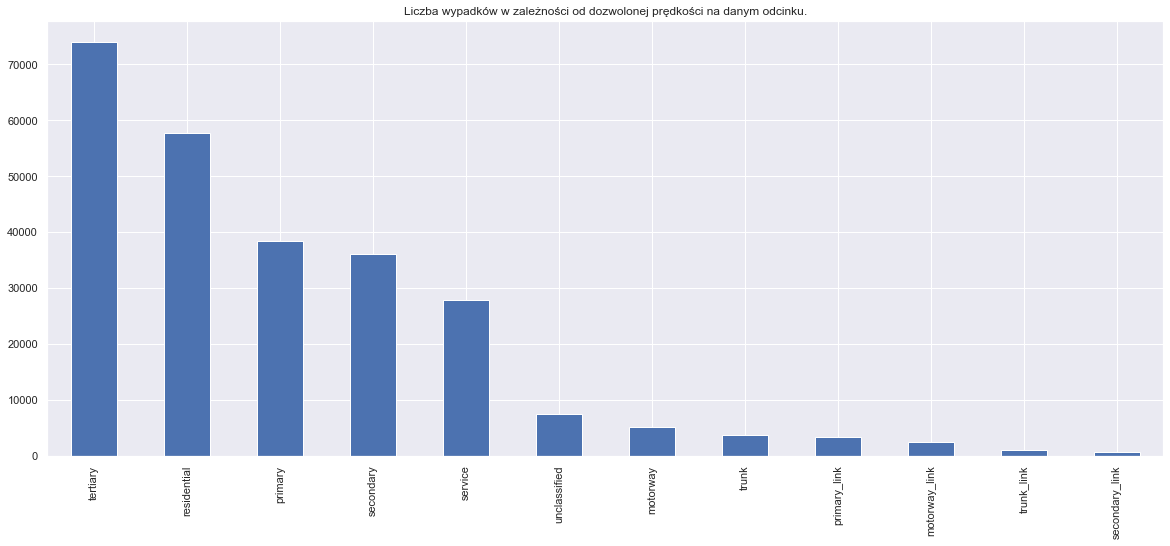

In [18]:
(
    accidents_only_roads_gdf["highway"].value_counts()
        .plot(kind="bar", title="Liczba wypadków w zależności od dozwolonej prędkości na danym odcinku.")
)